In [ ]:
#!source activate jgrace1

In [13]:
cd /disk/ocean/jgrace

/disk/ocean/jgrace


In [14]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [15]:
import unicodedata
import string
import re
import random
import time
import datetime
import math
import socket
hostname = socket.gethostname()

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence#, masked_cross_entropy
from torch.utils.data import Dataset, DataLoader

from masked_cross_entropy import *

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

from __future__ import unicode_literals, print_function, division
from io import open

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(1)

import pickle
import subprocess

In [16]:
import spacy
nlp = spacy.load('en_vectors_web_lg') # For the glove embeddings

In [17]:
import umap

%pylab inline
pylab.rcParams['figure.figsize'] = (20, 12)

Populating the interactive namespace from numpy and matplotlib


/afs/inf.ed.ac.uk/user/s04/s0451365/miniconda3/envs/jgrace1/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [18]:
# set which GPU to use
GPU_ID = 2
torch.cuda.set_device(GPU_ID)
print(torch.cuda.current_device())

2


In [19]:
USE_CUDA = torch.cuda.is_available()
print('Use_CUDA={}'.format(USE_CUDA))

if USE_CUDA:
    device = torch.device("cuda")
    print('current_device={}'.format(torch.cuda.current_device()))
else:
    device = torch.device("cpu")

Use_CUDA=True
current_device=2


In [20]:
torch.version.cuda

'8.0.61'

In [21]:
!nvidia-smi

Fri Aug 10 11:13:40 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.48                 Driver Version: 390.48                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX TIT...  Off  | 00000000:02:00.0 Off |                  N/A |
| 22%   26C    P8    15W / 250W |   4499MiB / 12212MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX TIT...  Off  | 00000000:83:00.0 Off |                  N/A |
| 23%   62C    P2    81W / 250W |   5370MiB / 12212MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [22]:
from seq2seq_utils import *

In [23]:
# global setting for seq2seq_utils
# set in seq2seq_utils - here just as a reminder

PAD = 0
BOS = 1
EOS = 2
UNK = 3

MAX_SRC_DOC_LENGTH = 1000
MAX_TGT_DOC_LENGTH = 100
MAX_DOC_LENGTH = 200

## Build models

### Encoder

In [24]:
class EncoderRNN(nn.Module):
    def __init__(self, embedding=None, rnn_type='LSTM', hidden_size=128, num_layers=1, dropout=0.3, bidirectional=True):
        super(EncoderRNN, self).__init__()
        
        self.num_layers = num_layers
        self.dropout = dropout
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        self.hidden_size = hidden_size // self.num_directions
        
        self.embedding = embedding
        self.word_vec_size = self.embedding.embedding_dim
        
        self.rnn_type = rnn_type
        self.rnn = getattr(nn, self.rnn_type)(
                           input_size=self.word_vec_size,
                           hidden_size=self.hidden_size,
                           num_layers=self.num_layers,
                           dropout=self.dropout, 
                           bidirectional=self.bidirectional)
        
    def forward(self, src_seqs, src_lens, hidden=None):
        """
        Args:
            - src_seqs: (max_src_len, batch_size)
            - src_lens: (batch_size)
        Returns:
            - outputs: (max_src_len, batch_size, hidden_size * num_directions)
            - hidden : (num_layers, batch_size, hidden_size * num_directions)
        """
        
        # (max_src_len, batch_size) => (max_src_len, batch_size, word_vec_size)
        emb = self.embedding(src_seqs)

        # packed_emb:
        # - data: (sum(batch_sizes), word_vec_size)
        # - batch_sizes: list of batch sizes
        packed_emb = nn.utils.rnn.pack_padded_sequence(emb, src_lens)

        # rnn(gru) returns:
        # - packed_outputs: shape same as packed_emb
        # - hidden: (num_layers * num_directions, batch_size, hidden_size) 
        packed_outputs, hidden = self.rnn(packed_emb, hidden)

        # outputs: (max_src_len, batch_size, hidden_size * num_directions)
        # output_lens == src_lensˇ
        outputs, output_lens =  nn.utils.rnn.pad_packed_sequence(packed_outputs)
        
        if self.bidirectional:
            # (num_layers * num_directions, batch_size, hidden_size) 
            # => (num_layers, batch_size, hidden_size * num_directions)
            hidden = self._cat_directions(hidden)
        
        return outputs, hidden
    
    def _cat_directions(self, hidden):
        """ If the encoder is bidirectional, do the following transformation.
            Ref: https://github.com/IBM/pytorch-seq2seq/blob/master/seq2seq/models/DecoderRNN.py#L176
            -----------------------------------------------------------
            In: (num_layers * num_directions, batch_size, hidden_size)
            (ex: num_layers=2, num_directions=2)

            layer 1: forward__hidden(1)
            layer 1: backward_hidden(1)
            layer 2: forward__hidden(2)
            layer 2: backward_hidden(2)

            -----------------------------------------------------------
            Out: (num_layers, batch_size, hidden_size * num_directions)

            layer 1: forward__hidden(1) backward_hidden(1)
            layer 2: forward__hidden(2) backward_hidden(2)
        """
        def _cat(h):
            return torch.cat([h[0:h.size(0):2], h[1:h.size(0):2]], 2)
            
        if isinstance(hidden, tuple):
            # LSTM hidden contains a tuple (hidden state, cell state)
            hidden = tuple([_cat(h) for h in hidden])
        else:
            # GRU hidden
            hidden = _cat(hidden)
            
        return hidden

### Decoder with "general attention" mechanism

In [25]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, encoder, embedding=None, attention=True, bias=True, tie_embeddings=False, dropout=0.3):
        """ General attention in `Effective Approaches to Attention-based Neural Machine Translation`
            Ref: https://arxiv.org/abs/1508.04025
            
            Share input and output embeddings:
            Ref:
                - "Using the Output Embedding to Improve Language Models" (Press & Wolf 2016)
                   https://arxiv.org/abs/1608.05859
                - "Tying Word Vectors and Word Classifiers: A Loss Framework for Language Modeling" (Inan et al. 2016)
                   https://arxiv.org/abs/1611.01462
        """
        super(LuongAttnDecoderRNN, self).__init__()
        
        self.hidden_size = encoder.hidden_size * encoder.num_directions
        self.num_layers = encoder.num_layers
        self.dropout = dropout
        self.embedding = embedding
        self.attention = attention
        self.tie_embeddings = tie_embeddings
        
        self.vocab_size = self.embedding.num_embeddings
        self.word_vec_size = self.embedding.embedding_dim
        
        self.rnn_type = encoder.rnn_type
        self.rnn = getattr(nn, self.rnn_type)(
                            input_size=self.word_vec_size,
                            hidden_size=self.hidden_size,
                            num_layers=self.num_layers,
                            dropout=self.dropout)
        
        if self.attention:
            self.W_a = nn.Linear(encoder.hidden_size * encoder.num_directions,
                                 self.hidden_size, bias=bias)
            self.W_c = nn.Linear(encoder.hidden_size * encoder.num_directions + self.hidden_size, 
                                 self.hidden_size, bias=bias)
        
        if self.tie_embeddings:
            self.W_proj = nn.Linear(self.hidden_size, self.word_vec_size, bias=bias)
            self.W_s = nn.Linear(self.word_vec_size, self.vocab_size, bias=bias)
            self.W_s.weight = self.embedding.weight
        else:
            self.W_s = nn.Linear(self.hidden_size, self.vocab_size, bias=bias)
        
    def forward(self, input_seq, decoder_hidden, encoder_outputs, src_lens):
        """ Args:
            - input_seq      : (batch_size)
            - decoder_hidden : (t=0) last encoder hidden state (num_layers * num_directions, batch_size, hidden_size) 
                               (t>0) previous decoder hidden state (num_layers, batch_size, hidden_size)
            - encoder_outputs: (max_src_len, batch_size, hidden_size * num_directions)
        
            Returns:
            - output           : (batch_size, vocab_size)
            - decoder_hidden   : (num_layers, batch_size, hidden_size)
            - attention_weights: (batch_size, max_src_len)
        """        
        # (batch_size) => (seq_len=1, batch_size)
        input_seq = input_seq.unsqueeze(0)
        
        # (seq_len=1, batch_size) => (seq_len=1, batch_size, word_vec_size) 
        emb = self.embedding(input_seq)
        
        # rnn returns:
        # - decoder_output: (seq_len=1, batch_size, hidden_size)
        # - decoder_hidden: (num_layers, batch_size, hidden_size)
        decoder_output, decoder_hidden = self.rnn(emb, decoder_hidden)

        # (seq_len=1, batch_size, hidden_size) => (batch_size, seq_len=1, hidden_size)
        decoder_output = decoder_output.transpose(0,1)
        
        """ 
        ------------------------------------------------------------------------------------------
        Notes of computing attention scores
        ------------------------------------------------------------------------------------------
        # For-loop version:

        max_src_len = encoder_outputs.size(0)
        batch_size = encoder_outputs.size(1)
        attention_scores = Variable(torch.zeros(batch_size, max_src_len))

        # For every batch, every time step of encoder's hidden state, calculate attention score.
        for b in range(batch_size):
            for t in range(max_src_len):
                # Loung. eq(8) -- general form content-based attention:
                attention_scores[b,t] = decoder_output[b].dot(attention.W_a(encoder_outputs[t,b]))

        ------------------------------------------------------------------------------------------
        # Vectorized version:

        1. decoder_output: (batch_size, seq_len=1, hidden_size)
        2. encoder_outputs: (max_src_len, batch_size, hidden_size * num_directions)
        3. W_a(encoder_outputs): (max_src_len, batch_size, hidden_size)
                        .transpose(0,1)  : (batch_size, max_src_len, hidden_size) 
                        .transpose(1,2)  : (batch_size, hidden_size, max_src_len)
        4. attention_scores: 
                        (batch_size, seq_len=1, hidden_size) * (batch_size, hidden_size, max_src_len) 
                        => (batch_size, seq_len=1, max_src_len)
        """
        
        if self.attention:
            # attention_scores: (batch_size, seq_len=1, max_src_len)
            attention_scores = torch.bmm(decoder_output, self.W_a(encoder_outputs).transpose(0,1).transpose(1,2))

            # attention_mask: (batch_size, seq_len=1, max_src_len)
            attention_mask = sequence_mask(src_lens).unsqueeze(1)

            # Fills elements of tensor with `-float('inf')` where `mask` is 1.
            attention_scores.data.masked_fill_(1 - attention_mask.data, -float('inf'))

            # attention_weights: (batch_size, seq_len=1, max_src_len) => (batch_size, max_src_len) for `F.softmax` 
            # => (batch_size, seq_len=1, max_src_len)
            try: # torch 0.3.x
                attention_weights = F.softmax(attention_scores.squeeze(1), dim=1).unsqueeze(1)
            except:
                attention_weights = F.softmax(attention_scores.squeeze(1)).unsqueeze(1)

            # context_vector:
            # (batch_size, seq_len=1, max_src_len) * (batch_size, max_src_len, encoder_hidden_size * num_directions)
            # => (batch_size, seq_len=1, encoder_hidden_size * num_directions)
            context_vector = torch.bmm(attention_weights, encoder_outputs.transpose(0,1))

            # concat_input: (batch_size, seq_len=1, encoder_hidden_size * num_directions + decoder_hidden_size)
            concat_input = torch.cat([context_vector, decoder_output], -1)

            # (batch_size, seq_len=1, encoder_hidden_size * num_directions + decoder_hidden_size) => (batch_size, seq_len=1, decoder_hidden_size)
            concat_output = F.tanh(self.W_c(concat_input))
            
            # Prepare returns:
            # (batch_size, seq_len=1, max_src_len) => (batch_size, max_src_len)
            attention_weights = attention_weights.squeeze(1)
        else:
            attention_weights = None
            concat_output = decoder_output
        
        # If input and output embeddings are tied,
        # project `decoder_hidden_size` to `word_vec_size`.
        if self.tie_embeddings:
            output = self.W_s(self.W_proj(concat_output))
        else:
            # (batch_size, seq_len=1, decoder_hidden_size) => (batch_size, seq_len=1, vocab_size)
            output = self.W_s(concat_output)    
        
        # Prepare returns:
        # (batch_size, seq_len=1, vocab_size) => (batch_size, vocab_size)
        output = output.squeeze(1)
        
        del src_lens
        
        return output, decoder_hidden, attention_weights

## Utils

In [26]:
def load_spacy_glove_embedding(spacy_nlp, vocab):
    
    vocab_size = len(vocab.token2id)
    word_vec_size = spacy_nlp.vocab.vectors_length
    embedding = np.zeros((vocab_size, word_vec_size))
    unk_count = 0
    
    print('='*100)
    print('Loading spacy glove embedding:')
    print('- Vocabulary size: {}'.format(vocab_size))
    print('- Word vector size: {}'.format(word_vec_size))
    
    for token, index in tqdm(vocab.token2id.items()):
        if token == vocab.id2token[PAD]: 
            continue
        elif token in [vocab.id2token[BOS], vocab.id2token[EOS], vocab.id2token[UNK]]: 
            vector = np.random.rand(word_vec_size,)
        elif spacy_nlp.vocab[token].has_vector: 
            vector = spacy_nlp.vocab[token].vector
        else:
            vector = embedding[UNK] 
            unk_count += 1
            
        embedding[index] = vector
        
    print('- Unknown word count: {}'.format(unk_count))
    print('='*100 + '\n')
    
    return torch.from_numpy(embedding).float()

def sequence_mask(sequence_length, max_len=None):
    """
    Caution: Input and Return are VARIABLE.
    """
    if max_len is None:
        #max_len = torch.max(sequence_length, 0) # not working. maybe outdated
        max_len, _ = sequence_length.max(0)
        
    batch_size = sequence_length.size(0)
    #seq_range = torch.arange(0, max_len).long() # not working. maybe outdated
    seq_range = torch.arange(0, max_len, out=torch.LongTensor())
    seq_range_expand = seq_range.unsqueeze(0).expand(batch_size, max_len)
    #seq_range_expand = seq_range_expand
    if sequence_length.is_cuda:
        seq_range_expand = seq_range_expand.cuda()
    seq_length_expand = (sequence_length.unsqueeze(1)
                         .expand_as(seq_range_expand))
    mask = seq_range_expand < seq_length_expand
    
    return mask

def masked_cross_entropy(logits, target, length):
    """
    Args:
        logits: A Variable containing a FloatTensor of size
            (batch, max_len, num_classes) which contains the
            unnormalized probability for each class.
        target: A Variable containing a LongTensor of size
            (batch, max_len) which contains the index of the true
            class for each corresponding step.
        length: A Variable containing a LongTensor of size (batch,)
            which contains the length of each data in a batch.
    Returns:
        loss: An average loss value masked by the length.
        
    The code is same as:
    
    weight = torch.ones(tgt_vocab_size)
    weight[padding_idx] = 0
    criterion = nn.CrossEntropyLoss(weight.cuda(), size_average)
    loss = criterion(logits_flat, losses_flat)
    """
    # logits_flat: (batch * max_len, num_classes)
    logits_flat = logits.view(-1, logits.size(-1))
    # log_probs_flat: (batch * max_len, num_classes)
    log_probs_flat = F.log_softmax(logits_flat)
    # target_flat: (batch * max_len, 1)
    target_flat = target.view(-1, 1)
    # losses_flat: (batch * max_len, 1)
    losses_flat = -torch.gather(log_probs_flat, dim=1, index=target_flat)
    # losses: (batch, max_len)
    losses = losses_flat.view(*target.size())
    # mask: (batch, max_len)
    mask = sequence_mask(sequence_length=length, max_len=target.size(1))
    # Note: mask need to bed casted to float!
    losses = losses * mask.float()
    loss = losses.sum() / mask.float().sum()
    
    # (batch_size * max_tgt_len,)
    pred_flat = log_probs_flat.max(1)[1]
    # (batch_size * max_tgt_len,) => (batch_size, max_tgt_len) => (max_tgt_len, batch_size)
    pred_seqs = pred_flat.view(*target.size()).transpose(0,1).contiguous()
    # (batch_size, max_len) => (batch_size * max_tgt_len,)
    mask_flat = mask.view(-1)
    
    # `.float()` IS VERY IMPORTANT !!!
    # https://discuss.pytorch.org/t/batch-size-and-validation-accuracy/4066/3
    num_corrects = int(pred_flat.eq(target_flat.squeeze(1)).masked_select(mask_flat).float().data.sum())
    num_words = length.data.sum()

    return loss, pred_seqs, num_corrects, num_words

def load_checkpoint(checkpoint_path):
    # It's weird that if `map_location` is not given, it will be extremely slow.
    return torch.load(checkpoint_path, map_location=lambda storage, loc: storage)

def save_checkpoint(opts, experiment_name, encoder, decoder1, decoder2, encoder_optim, decoder1_optim, decoder2_optim,
                    total_accuracy_d1, total_accuracy_d2, total_loss, global_step):
    checkpoint = {
        'opts': opts,
        'global_step': global_step,
        'encoder_state_dict': encoder.state_dict(),
        'decoder1_state_dict': decoder1.state_dict(),
        'decoder2_state_dict': decoder2.state_dict(),
        'encoder_optim_state_dict': encoder_optim.state_dict(),
        'decoder1_optim_state_dict': decoder1_optim.state_dict(),
        'decoder2_optim_state_dict': decoder2_optim.state_dict()
    }
    
    checkpoint_path = 'checkpoints/%s_acc_%.2f_loss_%.2f_step_%d.pt' % (experiment_name, total_accuracy_d1, total_loss, global_step)
    
    directory, filename = os.path.split(os.path.abspath(checkpoint_path))

    if not os.path.exists(directory):
        os.makedirs(directory)
    
    torch.save(checkpoint, checkpoint_path)
    
    return checkpoint_path

def variable2numpy(var):
    """ For tensorboard visualization """
    return var.data.cpu().numpy()

def write_to_tensorboard(writer, global_step, total_loss, total_corrects_d1, total_corrects_d2, total_words_d1, total_words_d2, total_accuracy_d1, total_accuracy_d2,
                         encoder_grad_norm, decoder1_grad_norm, decoder2_grad_norm, clipped_encoder_grad_norm, clipped_decoder1_grad_norm, clipped_decoder2_grad_norm,
                         encoder, decoder1, decoder2, gpu_memory_usage=None):
    # scalars
    if gpu_memory_usage is not None:
        writer.add_scalar('curr_gpu_memory_usage', gpu_memory_usage['curr'], global_step)
        writer.add_scalar('diff_gpu_memory_usage', gpu_memory_usage['diff'], global_step)
        
    writer.add_scalar('total_loss', total_loss, global_step)
    writer.add_scalar('total_accuracy_d1', total_accuracy_d1, global_step)
    writer.add_scalar('total_accuracy_d2', total_accuracy_d2, global_step)
    writer.add_scalar('total_corrects_d1', total_corrects_d1, global_step)
    writer.add_scalar('total_corrects_d2', total_corrects_d2, global_step)
    writer.add_scalar('total_words_d1', total_words_d1, global_step)
    writer.add_scalar('total_words_d2', total_words_d2, global_step)
    writer.add_scalar('encoder_grad_norm', encoder_grad_norm, global_step)
    writer.add_scalar('decoder1_grad_norm', decoder1_grad_norm, global_step)
    writer.add_scalar('decoder2_grad_norm', decoder2_grad_norm, global_step)
    writer.add_scalar('clipped_encoder_grad_norm', clipped_encoder_grad_norm, global_step)
    writer.add_scalar('clipped_decoder1_grad_norm', clipped_decoder1_grad_norm, global_step)
    writer.add_scalar('clipped_decoder2_grad_norm', clipped_decoder2_grad_norm, global_step)
    
    # histogram
    for name, param in encoder.named_parameters():
        name = name.replace('.', '/')
        writer.add_histogram('encoder/{}'.format(name), variable2numpy(param), global_step, bins='doane')
        if param.grad is not None:
            writer.add_histogram('encoder/{}/grad'.format(name), variable2numpy(param.grad), global_step, bins='doane')

    for name, param in decoder1.named_parameters():
        name = name.replace('.', '/')
        writer.add_histogram('decoder1/{}'.format(name), variable2numpy(param), global_step, bins='doane')
        if param.grad is not None:
            writer.add_histogram('decoder1/{}/grad'.format(name), variable2numpy(param.grad), global_step, bins='doane')
            
    for name, param in decoder2.named_parameters():
        name = name.replace('.', '/')
        writer.add_histogram('decoder2/{}'.format(name), variable2numpy(param), global_step, bins='doane')
        if param.grad is not None:
            writer.add_histogram('decoder2/{}/grad'.format(name), variable2numpy(param.grad), global_step, bins='doane')
            
def detach_hidden(hidden):
    """ Wraps hidden states in new Variables, to detach them from their history. Prevent OOM.
        After detach, the hidden's requires_grad=Fasle and grad_fn=None.
    Issues:
    - Memory leak problem in LSTM and RNN: https://github.com/pytorch/pytorch/issues/2198
    - https://github.com/pytorch/examples/blob/master/word_language_model/main.py
    - https://discuss.pytorch.org/t/help-clarifying-repackage-hidden-in-word-language-model/226
    - https://discuss.pytorch.org/t/solved-why-we-need-to-detach-variable-which-contains-hidden-representation/1426
    - 
    """
    if type(hidden) == Variable:
        hidden.detach_() # same as creating a new variable.
    else:
        for h in hidden: h.detach_()

def get_gpu_memory_usage(device_id):
    """Get the current gpu usage. """
    result = subprocess.check_output(
        [
            'nvidia-smi', '--query-gpu=memory.used',
            '--format=csv,nounits,noheader'
        ]).decode("utf-8")
    # Convert lines into a dictionary
    gpu_memory = [int(x) for x in result.strip().split('\n')]
    gpu_memory_map = dict(zip(range(len(gpu_memory)), gpu_memory))
    return gpu_memory_map[device_id]

## Trainer

In [27]:
def compute_grad_norm(parameters, norm_type=2):
    """ Ref: http://pytorch.org/docs/0.3.0/_modules/torch/nn/utils/clip_grad.html#clip_grad_norm
    """
    parameters = list(filter(lambda p: p.grad is not None, parameters))
    norm_type = float(norm_type)
    if norm_type == float('inf'):
        total_norm = max(p.grad.data.abs().max() for p in parameters)
    else:
        total_norm = 0
        for p in parameters:
            param_norm = p.grad.data.norm(norm_type)
            total_norm += param_norm ** norm_type
        total_norm = total_norm ** (1. / norm_type)
    return total_norm

def train(src_sents, tgt_sents, tgt_tags, src_seqs, tgt1_seqs, tgt2_seqs, src_lens, tgt1_lens, tgt2_lens,
          encoder, decoder1, decoder2, encoder_optim, decoder1_optim,decoder2_optim, opts):    
    # -------------------------------------
    # Prepare input and output placeholders
    # -------------------------------------
    # Last batch might not have the same size as we set to the `batch_size`
    batch_size = src_seqs.size(1)
    assert(batch_size == tgt1_seqs.size(1))
    assert(batch_size == tgt2_seqs.size(1))
    
    # Pack tensors to variables for neural network inputs (in order to autograd)
    src_seqs = src_seqs
    tgt1_seqs = tgt1_seqs
    tgt2_seqs = tgt2_seqs
    src_lens = torch.LongTensor(src_lens)
    tgt1_lens = torch.LongTensor(tgt1_lens)
    tgt2_lens = torch.LongTensor(tgt2_lens)

    # Decoder's input
    input_seq = torch.LongTensor([BOS] * batch_size)
    
    # Decoder's output sequence length = max target sequence length of current batch.
    max_tgt1_len = tgt1_lens.data.max()
    max_tgt2_len = tgt2_lens.data.max()
    
    # Store all decoder's outputs.

    decoder1_outputs = torch.zeros(opts.max_seq_len, batch_size, decoder1.vocab_size)
    decoder2_outputs = torch.zeros(opts.max_seq_len, batch_size, decoder2.vocab_size)

    # Move variables from CPU to GPU.
    if USE_CUDA:
        src_seqs = src_seqs.cuda()
        tgt1_seqs = tgt1_seqs.cuda()
        tgt2_seqs = tgt2_seqs.cuda()
        src_lens = src_lens.cuda()
        tgt1_lens = tgt1_lens.cuda()
        tgt2_lens = tgt2_lens.cuda()
        input_seq = input_seq.cuda()
        decoder1_outputs = decoder1_outputs.cuda()
        decoder2_outputs = decoder2_outputs.cuda()
        
    # -------------------------------------
    # Training mode (enable dropout)
    # -------------------------------------
    encoder.train()
    decoder1.train()
    decoder2.train()
    
    # -------------------------------------
    # Zero gradients, since optimizers will accumulate gradients for every backward.
    # -------------------------------------
    encoder_optim.zero_grad()
    decoder1_optim.zero_grad()
    decoder2_optim.zero_grad()
        
    # -------------------------------------
    # Forward encoder
    # -------------------------------------
    encoder_outputs, encoder_hidden = encoder(src_seqs, src_lens.data.tolist())

    # -------------------------------------
    # Forward decoder
    # -------------------------------------
    # Initialize decoder's hidden state as encoder's last hidden state.
    decoder1_hidden = encoder_hidden
    decoder2_hidden = encoder_hidden
    
    # Run through decoder one time step at a time.
    for t in range(max_tgt1_len):
        
        # decoder returns:
        # - decoder_output   : (batch_size, vocab_size)
        # - decoder_hidden   : (num_layers, batch_size, hidden_size)
        # - attention_weights: (batch_size, max_src_len)
        decoder1_output, decoder1_hidden, attention_weights_d1 = decoder1(input_seq, decoder1_hidden,
                                                                    encoder_outputs, src_lens)
        
        # Store decoder outputs.
        decoder1_outputs[t] = decoder1_output
        
        # Next input is current target
        input_seq = tgt1_seqs[t]
        
        # Detach hidden state:
        detach_hidden(decoder1_hidden)
    
    for t in range(max_tgt2_len):   
        
        decoder2_output, decoder2_hidden, attention_weights_d2 = decoder2(input_seq, decoder2_hidden,
                                                                    encoder_outputs, src_lens)

        
        decoder2_outputs[t] = decoder2_output
        
        # Next input is current target
        input_seq = tgt2_seqs[t]
        

        detach_hidden(decoder2_hidden)
        
    # -------------------------------------
    # Compute losses
    # -------------------------------------
    loss_d1, pred_seqs_d1, num_corrects_d1, num_words_d1 = masked_cross_entropy(
        decoder1_outputs[:max_tgt1_len].transpose(0,1).contiguous(), 
        tgt1_seqs.transpose(0,1).contiguous(),
        tgt1_lens
    )
    
    loss_d2, pred_seqs_d2, num_corrects_d2, num_words_d2 = masked_cross_entropy(
        decoder2_outputs[:max_tgt2_len].transpose(0,1).contiguous(), 
        tgt2_seqs.transpose(0,1).contiguous(),
        tgt2_lens
    )
    
    pred_seqs_d1 = pred_seqs_d1[:max_tgt1_len]
    pred_seqs_d2 = pred_seqs_d2[:max_tgt2_len]
    
    loss = loss_d1 + loss_d2
    # -------------------------------------
    # Backward and optimize
    # -------------------------------------
    # Backward to get gradients w.r.t parameters in model.
    loss.backward()
    
    # Clip gradients
    encoder_grad_norm = nn.utils.clip_grad_norm(encoder.parameters(), opts.max_grad_norm)
    decoder1_grad_norm = nn.utils.clip_grad_norm(decoder1.parameters(), opts.max_grad_norm)
    decoder2_grad_norm = nn.utils.clip_grad_norm(decoder2.parameters(), opts.max_grad_norm)
    clipped_encoder_grad_norm = compute_grad_norm(encoder.parameters())
    clipped_decoder1_grad_norm = compute_grad_norm(decoder1.parameters())
    clipped_decoder2_grad_norm = compute_grad_norm(decoder2.parameters())
    
    # Update parameters with optimizers
    encoder_optim.step()
    decoder1_optim.step()
    decoder2_optim.step()
        
    return loss.data[0], pred_seqs_d1, pred_seqs_d2, attention_weights_d1,attention_weights_d2, num_corrects_d1,num_corrects_d2, num_words_d1, num_words_d2,\
           encoder_grad_norm, decoder1_grad_norm,decoder2_grad_norm, clipped_encoder_grad_norm, clipped_decoder1_grad_norm, clipped_decoder2_grad_norm

In [28]:
train_dataset = MultitaskNMTDataset(src_path='data/src-train.txt',
                           tgt1_path='data/tgt-train.txt', tgt2_path='data/tgt-tags-train.txt')

Dataset preprocessing log:
- Loading and tokenizing source sentences...



- Loading and tokenizing target sentences...



- Building source counter...



- Building target counter...



- Building source vocabulary...



- Building target vocabulary...



Dataset Info:
- Number of source sentences: 204061
- Number of target sentences: 204061
- Number of target tags: 204061
- Source vocabulary size: 50004
- Target 1 vocabulary size: 50004
- Target 2 vocabulary size: 10499
- Shared vocabulary: True



In [29]:
valid_dataset = MultitaskNMTDataset(src_path='data/src-val.txt',
                           tgt1_path='data/tgt-val.txt',
                            tgt2_path='data/tgt-tags-dev.txt',
                           src_vocab=train_dataset.src_vocab,
                           tgt1_vocab=train_dataset.tgt1_vocab,
                            tgt2_vocab=train_dataset.tgt2_vocab)

Dataset preprocessing log:
- Loading and tokenizing source sentences...



- Loading and tokenizing target sentences...



Dataset Info:
- Number of source sentences: 25507
- Number of target sentences: 25507
- Number of target tags: 25507
- Source vocabulary size: 50004
- Target 1 vocabulary size: 50004
- Target 2 vocabulary size: 10499
- Shared vocabulary: True



In [30]:
test_dataset_short = MultitaskNMTDataset(src_path='data/src-test-shrt.txt',
                           tgt1_path='data/tgt-test-shrt.txt',
                            tgt2_path='data/tgt-tags-test-shrt.txt',
                           src_vocab=train_dataset.src_vocab,
                           tgt1_vocab=train_dataset.tgt1_vocab,
                             tgt2_vocab=train_dataset.tgt2_vocab)

Dataset preprocessing log:
- Loading and tokenizing source sentences...



- Loading and tokenizing target sentences...



Dataset Info:
- Number of source sentences: 3000
- Number of target sentences: 3000
- Number of target tags: 3000
- Source vocabulary size: 50004
- Target 1 vocabulary size: 50004
- Target 2 vocabulary size: 10499
- Shared vocabulary: True



In [31]:
## get section labels

file_path = 'data/valid_section_labs.txt'
val_section_labels = []

with codecs.open(file_path) as file:
    for sent in file.readlines():
        val_section_labels.append(sent[:-1])
        
file_path = 'data/train_section_labs.txt'
train_section_labels = []

with codecs.open(file_path) as file:
    for sent in file.readlines():
        train_section_labels.append(sent[:-1])
        

In [32]:
train_mlp_dataset = MLPDataset(src_path='data/src-train.txt',
                           tgt_path='data/train_section_data', MAX_SRC_DOC_LENGTH=400)

Dataset preprocessing log:
- Loading and tokenizing source sentences...



- Loading targets


In [33]:
valid_mlp_dataset = MLPDataset(src_path='data/src-val.txt',
                           tgt_path='data/val_section_data', MAX_SRC_DOC_LENGTH=400)

Dataset preprocessing log:
- Loading and tokenizing source sentences...



- Loading targets


In [34]:
batch_size = 8

train_iter = DataLoader(dataset=train_dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=4,
                        collate_fn=multitask_collate_fn)

valid_iter = DataLoader(dataset=valid_dataset,
                        batch_size=batch_size, 
                        shuffle=False,
                        num_workers=4,
                        collate_fn=multitask_collate_fn)


In [35]:
batch_size = 4

test_shrt_iter = DataLoader(dataset=test_dataset_short,
                        batch_size=batch_size, 
                        shuffle=False,
                        num_workers=4,
                        collate_fn=multitask_collate_fn)

In [36]:
batch_size = 128

train_mlp_iter = DataLoader(dataset=train_mlp_dataset,
                        batch_size=batch_size, 
                        shuffle=True,
                        num_workers=4,
                        collate_fn=collate_fn2)

In [37]:
batch_size = 8

valid_mlp_iter = DataLoader(dataset=valid_mlp_dataset,
                        batch_size=batch_size, 
                        shuffle=False,
                        num_workers=4,
                        collate_fn=collate_fn2)

In [38]:
# If enabled, load checkpoint.
LOAD_CHECKPOINT = True

if LOAD_CHECKPOINT:
    # Modify this path.
    checkpoint_path = './checkpoints/seq2seq_luong_multitask_2018-08-08 19:04:01_acc_28.61_loss_806.81_step_45000.pt'
    checkpoint = load_checkpoint(checkpoint_path)
    opts = checkpoint['opts']    
else:
    opts = AttrDict()

    # Configure models
    opts.word_vec_size = 300
    opts.rnn_type = 'LSTM'
    opts.hidden_size = 512
    opts.num_layers = 2
    opts.dropout = 0.3
    opts.bidirectional = True
    opts.attention = True
    opts.share_embeddings = False
    opts.pretrained_embeddings = True
    opts.fixed_embeddings = True
    opts.tie_embeddings = True # Tie decoder's input and output embeddings

    # Configure optimization
    opts.max_grad_norm = 2
    opts.learning_rate = 0.001
    opts.weight_decay = 1e-5 # L2 weight regularization
    
    # Configure training
    opts.max_seq_len = 500 # max sequence length to prevent OOM.
    opts.num_epochs = 3
    opts.print_every_step = 100
    opts.save_every_step = 5000

In [39]:
print('='*100)
print('Options log:')
print('- Load from checkpoint: {}'.format(LOAD_CHECKPOINT))
if LOAD_CHECKPOINT: print('- Global step: {}'.format(checkpoint['global_step']))
for k,v in opts.items(): print('- {}: {}'.format(k, v))
print('='*100 + '\n')

Options log:
- Load from checkpoint: True
- Global step: 45000
- pretrained_embeddings: True
- max_seq_len: 500
- num_layers: 2
- save_every_step: 5000
- word_vec_size: 300
- fixed_embeddings: True
- num_epochs: 3
- bidirectional: True
- weight_decay: 1e-05
- print_every_step: 100
- dropout: 0.3
- max_grad_norm: 2
- attention: True
- tie_embeddings: True
- share_embeddings: False
- learning_rate: 0.001
- hidden_size: 512
- rnn_type: LSTM



## Initialize embeddings and models

In [40]:
# Initialize vocabulary size.
src_vocab_size = len(train_dataset.src_vocab.token2id)
tgt1_vocab_size = len(train_dataset.tgt1_vocab.token2id)
tgt2_vocab_size = len(train_dataset.tgt2_vocab.token2id)

# Initialize embeddings.
# We can actually put all modules in one module like `NMTModel`)
# See: https://github.com/spro/practical-pytorch/issues/34
word_vec_size = opts.word_vec_size if not opts.pretrained_embeddings else nlp.vocab.vectors_length
src_embedding = nn.Embedding(src_vocab_size, opts.word_vec_size, padding_idx=PAD)
tgt1_embedding = nn.Embedding(tgt1_vocab_size, opts.word_vec_size, padding_idx=PAD)
tgt2_embedding = nn.Embedding(tgt2_vocab_size, opts.word_vec_size, padding_idx=PAD)

if opts.share_embeddings:
    assert(src_vocab_size == tgt1_vocab_size)
    tgt_embedding.weight = src_embedding.weight

# Initialize models.
encoder = EncoderRNN(embedding=src_embedding,
                     rnn_type=opts.rnn_type,
                     hidden_size=opts.hidden_size,
                     num_layers=opts.num_layers,
                     dropout=opts.dropout,
                     bidirectional=opts.bidirectional)

decoder1 = LuongAttnDecoderRNN(encoder, embedding=tgt1_embedding,
                              attention=opts.attention,
                              tie_embeddings=opts.tie_embeddings,
                              dropout=opts.dropout)

decoder2 = LuongAttnDecoderRNN(encoder, embedding=tgt2_embedding,
                              attention=opts.attention,
                              tie_embeddings=opts.tie_embeddings,
                              dropout=opts.dropout)

if opts.pretrained_embeddings:
    glove_embeddings = load_spacy_glove_embedding(nlp, train_dataset.src_vocab)
    encoder.embedding.weight.data.copy_(glove_embeddings)
    decoder1.embedding.weight.data.copy_(glove_embeddings)
    if opts.fixed_embeddings:
        encoder.embedding.weight.requires_grad = False
        decoder1.embedding.weight.requires_grad = False
        decoder2.embedding.weight.requires_grad = False
        
if LOAD_CHECKPOINT:
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    decoder1.load_state_dict(checkpoint['decoder1_state_dict'])
    decoder2.load_state_dict(checkpoint['decoder2_state_dict'])
    
# Move models to GPU (need time for initial run)
if USE_CUDA:
    encoder.cuda()
    decoder1.cuda()
    decoder2.cuda()

Loading spacy glove embedding:
- Vocabulary size: 50004
- Word vector size: 300



- Unknown word count: 4501



In [41]:
FINE_TUNE = True
if FINE_TUNE:
    encoder.embedding.weight.requires_grad = True

In [42]:
print('='*100)
print('Model log:\n')
print(encoder)
print(decoder1)
print(decoder2)
print('- Encoder input embedding requires_grad={}'.format(encoder.embedding.weight.requires_grad))
print('- Decoder 1 input embedding requires_grad={}'.format(decoder1.embedding.weight.requires_grad))
print('- Decoder 2 input embedding requires_grad={}'.format(decoder2.embedding.weight.requires_grad))
print('- Decoder 1 output embedding requires_grad={}'.format(decoder1.W_s.weight.requires_grad))
print('- Decoder 2 output embedding requires_grad={}'.format(decoder2.W_s.weight.requires_grad))
print('='*100 + '\n')

Model log:

EncoderRNN(
  (embedding): Embedding(50004, 300, padding_idx=0)
  (rnn): LSTM(300, 256, num_layers=2, dropout=0.3, bidirectional=True)
)
LuongAttnDecoderRNN(
  (embedding): Embedding(50004, 300, padding_idx=0)
  (rnn): LSTM(300, 512, num_layers=2, dropout=0.3)
  (W_a): Linear(in_features=512, out_features=512, bias=True)
  (W_c): Linear(in_features=1024, out_features=512, bias=True)
  (W_proj): Linear(in_features=512, out_features=300, bias=True)
  (W_s): Linear(in_features=300, out_features=50004, bias=True)
)
LuongAttnDecoderRNN(
  (embedding): Embedding(10499, 300, padding_idx=0)
  (rnn): LSTM(300, 512, num_layers=2, dropout=0.3)
  (W_a): Linear(in_features=512, out_features=512, bias=True)
  (W_c): Linear(in_features=1024, out_features=512, bias=True)
  (W_proj): Linear(in_features=512, out_features=300, bias=True)
  (W_s): Linear(in_features=300, out_features=10499, bias=True)
)
- Encoder input embedding requires_grad=True
- Decoder 1 input embedding requires_grad=Fals

In [43]:
# Initialize optimizers (we can experiment different learning rates)
encoder_optim = optim.Adam([p for p in encoder.parameters() if p.requires_grad], lr=opts.learning_rate, weight_decay=opts.weight_decay)
decoder1_optim = optim.Adam([p for p in decoder1.parameters() if p.requires_grad], lr=opts.learning_rate, weight_decay=opts.weight_decay)
decoder2_optim = optim.Adam([p for p in decoder2.parameters() if p.requires_grad], lr=opts.learning_rate, weight_decay=opts.weight_decay)

## Train model

In [90]:
""" Open port 6006 and see tensorboard.
    Ref:  https://medium.com/@dexterhuang/%E7%B5%A6-pytorch-%E7%94%A8%E7%9A%84-tensorboard-bb341ce3f837
"""
from datetime import datetime
from tensorboardX import SummaryWriter
# --------------------------
# Configure tensorboard
# --------------------------
model_name = 'seq2seq_luong_multitask'
datetime = ('%s' % datetime.now()).split('.')[0]
experiment_name = '{}_{}'.format(model_name, datetime)
tensorboard_log_dir = './tensorboard-logs/{}/'.format(experiment_name)
writer = SummaryWriter(tensorboard_log_dir)

# --------------------------
# Configure training
# --------------------------
num_epochs = opts.num_epochs
print_every_step = opts.print_every_step
save_every_step = opts.save_every_step
# For saving checkpoint and tensorboard
global_step = 0 if not LOAD_CHECKPOINT else checkpoint['global_step']

# --------------------------
# Start training
# --------------------------
total_loss = 0
total_corrects_d1 = 0
total_corrects_d2 = 0
total_words_d1 = 0
total_words_d2 = 0
prev_gpu_memory_usage = 0

In [ ]:
for epoch in range(num_epochs):
    for batch_id, batch_data in tqdm(enumerate(train_iter)):

        # Unpack batch data
        src_sents, tgt_sents, tgt_tags, src_seqs, tgt1_seqs, tgt2_seqs, src_lens, tgt1_lens, tgt2_lens = batch_data
        
        # Ignore batch if there is a long sequence.
        max_seq_len = max(src_lens + tgt1_lens)
        if max_seq_len > opts.max_seq_len:
            print('[!] Ignore batch: sequence length={} > max sequence length={}'.format(max_seq_len, opts.max_seq_len))
            continue
        
        # Train.
        loss, pred_seqs_d1, pred_seqs_d2, attention_weights_d1, attention_weights_d2, num_corrects_d1, num_corrects_d2, num_words_d1, num_words_d2, \
        encoder_grad_norm, decoder1_grad_norm, decoder2_grad_norm, clipped_encoder_grad_norm, clipped_decoder1_grad_norm, clipped_decoder2_grad_norm \
        = train(src_sents, tgt_sents, tgt_tags, src_seqs, tgt1_seqs, tgt2_seqs, src_lens, tgt1_lens, tgt2_lens, encoder, decoder1, decoder2, encoder_optim, decoder1_optim, decoder2_optim, opts)

        # Statistics.
        global_step += 1
        total_loss += loss
        total_corrects_d1 += num_corrects_d1
        total_corrects_d2 += num_corrects_d2
        total_words_d1 += num_words_d1
        total_words_d2 += num_words_d2
        total_accuracy_d1 = 100 * (total_corrects_d1 / total_words_d1.item())
        total_accuracy_d2 = 100 * (total_corrects_d2 / total_words_d2.item())
        
        # Save checkpoint.
        if global_step % save_every_step == 0:
            
            checkpoint_path = save_checkpoint(opts, experiment_name, encoder, decoder1, decoder2, encoder_optim, decoder1_optim, decoder2_optim,
                                              total_accuracy_d1, total_accuracy_d2, total_loss, global_step)
            
            print('='*100)
            print('Save checkpoint to "{}".'.format(checkpoint_path))
            print('='*100 + '\n')

        # Print statistics and write to Tensorboard.
        if global_step % print_every_step == 0:
            
            curr_gpu_memory_usage = get_gpu_memory_usage(device_id=torch.cuda.current_device())
            diff_gpu_memory_usage = curr_gpu_memory_usage - prev_gpu_memory_usage
            prev_gpu_memory_usage = curr_gpu_memory_usage
            
            print('='*100)
            print('Training log:')
            print('- Epoch: {}/{}'.format(epoch, num_epochs))
            print('- Global step: {}'.format(global_step))
            print('- Total loss: {}'.format(total_loss))
            print('- Total corrects d1: {}'.format(total_corrects_d1))
            print('- Total corrects d2: {}'.format(total_corrects_d2))
            print('- Total words d1: {}'.format(total_words_d1))
            print('- Total words d2: {}'.format(total_words_d2))
            print('- Total accuracy d1: {}'.format(total_accuracy_d1))
            print('- Total accuracy d2: {}'.format(total_accuracy_d2))
            print('- Current GPU memory usage: {}'.format(curr_gpu_memory_usage))
            print('- Diff GPU memory usage: {}'.format(diff_gpu_memory_usage))
            print('='*100 + '\n')
            
            write_to_tensorboard(writer, global_step, total_loss, total_corrects_d1,total_corrects_d2, total_words_d1,total_words_d2, total_accuracy_d1,total_accuracy_d2,
                                 encoder_grad_norm, decoder1_grad_norm,decoder1_grad_norm, clipped_encoder_grad_norm, clipped_decoder1_grad_norm,clipped_decoder2_grad_norm,
                                 encoder, decoder1,decoder2,
                                 gpu_memory_usage={
                                     'curr': curr_gpu_memory_usage,
                                     'diff': diff_gpu_memory_usage
                                 })
            
            total_loss = 0
            total_corrects_d1 = 0
            total_corrects_d2 = 0
            total_words_d1 = 0
            total_words_d2 = 0

        # Free memory
        del src_sents, tgt_sents, tgt_tags, src_seqs, tgt1_seqs, tgt2_seqs, src_lens, tgt1_lens, tgt2_lens, \
            loss, pred_seqs_d1, pred_seqs_d2, attention_weights_d1, attention_weights_d2, num_corrects_d1, num_corrects_d2, num_words_d1, num_words_d2, \
            encoder_grad_norm, decoder1_grad_norm, decoder2_grad_norm, clipped_encoder_grad_norm, clipped_decoder1_grad_norm, clipped_decoder2_grad_norm

In [ ]:
checkpoint_path = save_checkpoint(opts, experiment_name, encoder, decoder1,decoder2, encoder_optim, decoder1_optim, decoder2_optim,
                                              total_accuracy_d1,total_accuracy_d2, total_loss, global_step)
            
print('='*100)
print('Save checkpoint to "{}".'.format(checkpoint_path))
print('='*100 + '\n')

## Evaluation

In [26]:
def evaluate(src_sents, tgt_sents, tgt_tags, src_seqs, tgt1_seqs, tgt2_seqs, src_lens, tgt1_lens, tgt2_lens, encoder, decoder1, decoder2):
    # -------------------------------------
    # Prepare input and output placeholders
    # -------------------------------------
    # Last batch might not have the same size as we set to the `batch_size`
    batch_size = src_seqs.size(1)
    assert(batch_size == tgt1_seqs.size(1))
    assert(batch_size == tgt2_seqs.size(1))
    
    # Pack tensors to variables for neural network inputs (in order to autograd)
    with torch.no_grad():
        src_seqs = src_seqs
        tgt1_seqs = tgt1_seqs
        tgt2_seqs = tgt2_seqs
        src_lens = torch.LongTensor(src_lens)
        tgt1_lens = torch.LongTensor(tgt1_lens)
        tgt2_lens = torch.LongTensor(tgt2_lens)

    # Decoder's input
        input_seq = torch.LongTensor([BOS] * batch_size)
    
    # Decoder's output sequence length = max target sequence length of current batch.
        max_tgt1_len = tgt1_lens.data.max()
        max_tgt2_len = tgt2_lens.data.max()
    
    # Store all decoder's outputs.
    # **CRUTIAL** 
    # Don't set:
    # >> decoder_outputs = Variable(torch.zeros(max_tgt_len, batch_size, decoder.vocab_size))
    # Varying tensor size could cause GPU allocate a new memory causing OOM, 
    # so we intialize tensor with fixed size instead:
    # `opts.max_seq_len` is a fixed number, unlike `max_tgt_len` always varys.
        decoder1_outputs = torch.zeros(opts.max_seq_len, batch_size, decoder1.vocab_size)
        decoder2_outputs = torch.zeros(opts.max_seq_len, batch_size, decoder2.vocab_size)

    # Move variables from CPU to GPU.
    if USE_CUDA:
        src_seqs = src_seqs.cuda()
        tgt1_seqs = tgt1_seqs.cuda()
        tgt2_seqs = tgt2_seqs.cuda()
        src_lens = src_lens.cuda()
        tgt1_lens = tgt1_lens.cuda()
        tgt2_lens = tgt2_lens.cuda()
        input_seq = input_seq.cuda()
        decoder1_outputs = decoder1_outputs.cuda()
        decoder2_outputs = decoder2_outputs.cuda()
        
    # -------------------------------------
    # Evaluation mode (disable dropout)
    # -------------------------------------
    encoder.eval()
    decoder1.eval()
    decoder2.eval()
            
    # -------------------------------------
    # Forward encoder
    # -------------------------------------
    with torch.no_grad():
        encoder_outputs, encoder_hidden = encoder(src_seqs, src_lens.data.tolist())

        # -------------------------------------
        # Forward decoder
        # -------------------------------------
        # Initialize decoder's hidden state as encoder's last hidden state.
        decoder1_hidden = encoder_hidden
        decoder2_hidden = encoder_hidden

        # Run through decoder one time step at a time.
        for t in range(max_tgt1_len):

            # decoder returns:
            # - decoder_output   : (batch_size, vocab_size)
            # - decoder_hidden   : (num_layers, batch_size, hidden_size)
            # - attention_weights: (batch_size, max_src_len)
            decoder1_output, decoder1_hidden, attention_weights_d1 = decoder1(input_seq, decoder1_hidden,
                                                                        encoder_outputs, src_lens)

            # Store decoder outputs.
            decoder1_outputs[t] = decoder1_output

            # Next input is current target
            input_seq = tgt1_seqs[t]

            # Detach hidden state (may not need this, since no BPTT)
            detach_hidden(decoder1_hidden)
            
        for t in range(max_tgt2_len):

            # decoder returns:
            # - decoder_output   : (batch_size, vocab_size)
            # - decoder_hidden   : (num_layers, batch_size, hidden_size)
            # - attention_weights: (batch_size, max_src_len)
            decoder2_output, decoder2_hidden, attention_weights_d2 = decoder2(input_seq, decoder2_hidden,
                                                                        encoder_outputs, src_lens)

            # Store decoder outputs.
            decoder2_outputs[t] = decoder2_output

            # Next input is current target
            input_seq = tgt2_seqs[t]

            # Detach hidden state (may not need this, since no BPTT)
            detach_hidden(decoder2_hidden)

        # -------------------------------------
        # Compute loss
        # -------------------------------------
        loss_d1, pred_seqs_d1, num_corrects_d1, num_words_d1 = masked_cross_entropy(
            decoder1_outputs[:max_tgt1_len].transpose(0,1).contiguous(), 
            tgt1_seqs.transpose(0,1).contiguous(),
            tgt1_lens
        )
        
        loss_d2, pred_seqs_d2, num_corrects_d2, num_words_d2 = masked_cross_entropy(
            decoder2_outputs[:max_tgt2_len].transpose(0,1).contiguous(), 
            tgt2_seqs.transpose(0,1).contiguous(),
            tgt2_lens
        )
        
        loss = loss_d1 + loss_d2

        pred_seqs_d1 = pred_seqs_d1[:max_tgt1_len]
        pred_seqs_d2 = pred_seqs_d2[:max_tgt2_len]
    
    return loss.data[0], pred_seqs_d1,pred_seqs_d2, attention_weights_d1,attention_weights_d2, num_corrects_d1,num_corrects_d2, num_words_d1,num_words_d2

In [93]:
total_loss = 0
total_corrects_d1 = 0
total_words_d1 = 0
total_corrects_d2 = 0
total_words_d2 = 0

for batch_id, batch_data in tqdm(enumerate(valid_iter)):
    src_sents, tgt_sents, tgt_tags, src_seqs, tgt1_seqs,tgt2_seqs, src_lens, tgt1_lens,tgt2_lens = batch_data
    
    loss, pred_seqs_d1,pred_seqs_d2, attention_weights_d1,attention_weights_d2, num_corrects_d1,num_corrects_d2, num_words_d1,num_words_d2 \
        = evaluate(src_sents, tgt_sents, tgt_tags, src_seqs, tgt1_seqs, tgt2_seqs, src_lens, tgt1_lens, tgt2_lens, encoder, decoder1, decoder2)
        
    total_loss += loss
    total_corrects_d1 += num_corrects_d1
    total_corrects_d2 += num_corrects_d2
    total_words_d1 += num_words_d1
    total_words_d2 += num_words_d2
    total_accuracy_d1 = 100 * (total_corrects_d1 / total_words_d1.item())
    total_accuracy_d2 = 100 * (total_corrects_d2 / total_words_d2.item())

print('='*100)
print('Validation log:')
print('- Total loss: {}'.format(total_loss))
print('- Total corrects_d1: {}'.format(total_corrects_d1))
print('- Total corrects_d2: {}'.format(total_corrects_d2))
print('- Total words d1: {}'.format(total_words_d1))
print('- Total words d2: {}'.format(total_words_d2))
print('- Total accuracy d1: {}'.format(total_accuracy_d1))
print('- Total accuracy d2: {}'.format(total_accuracy_d2))
print('='*100 + '\n')

/afs/inf.ed.ac.uk/user/s04/s0451365/miniconda3/envs/jgrace1/lib/python3.5/site-packages/ipykernel/__main__.py:73: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/afs/inf.ed.ac.uk/user/s04/s0451365/miniconda3/envs/jgrace1/lib/python3.5/site-packages/ipykernel/__main__.py:125: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



Validation log:
- Total loss: 29276.8515625
- Total corrects_d1: 267830
- Total corrects_d2: 114876
- Total words d1: 983709
- Total words d2: 236931
- Total accuracy d1: 27.22654768839159
- Total accuracy d2: 48.485001962596705



## Translate (inference)

In [33]:
def translate(src_text, train_dataset, encoder, decoder1, decoder2, max_sum_len, max_tag_len, replace_unk=True):
    # -------------------------------------
    # Prepare input and output placeholders
    # -------------------------------------
    # Like dataset's `__getitem__()` and dataloader's `collate_fn()`.
    src_sent = src_text.split()
    src_seqs = torch.LongTensor([train_dataset.tokens2ids(tokens=src_text.split(),
                                                          token2id=train_dataset.src_vocab.token2id,
                                                          append_BOS=False, append_EOS=True)]).transpose(0,1)
    src_lens = [len(src_seqs)]
    
    # Last batch might not have the same size as we set to the `batch_size`
    batch_size = src_seqs.size(1)
    
    # Pack tensors to variables for neural network inputs (in order to autograd)
    with torch.no_grad():
        src_seqs = src_seqs
        src_lens = torch.LongTensor(src_lens)

    # Decoder's input
        input_seq = torch.LongTensor([BOS] * batch_size)
    # Store output words and attention states
        out_sent = []
        out_tags = []
        all_attention_weights_d1 = torch.zeros(max_sum_len, len(src_seqs))
        all_attention_weights_d2 = torch.zeros(max_tag_len, len(src_seqs))
    
    # Move variables from CPU to GPU.
    if USE_CUDA:
        src_seqs = src_seqs.cuda()
        src_lens = src_lens.cuda()
        input_seq = input_seq.cuda()
        
    # -------------------------------------
    # Evaluation mode (disable dropout)
    # -------------------------------------
    encoder.eval()
    decoder1.eval()
    decoder2.eval()
        
    # -------------------------------------
    # Forward encoder
    # -------------------------------------
    with torch.no_grad():
        encoder_outputs, encoder_hidden = encoder(src_seqs, src_lens.data.tolist())

        # -------------------------------------
        # Forward decoder
        # -------------------------------------
        # Initialize decoder's hidden state as encoder's last hidden state.
        decoder1_hidden = encoder_hidden
        decoder2_hidden = encoder_hidden

        # Run through decoder one time step at a time.
        for t in range(max_sum_len):

            # decoder returns:
            # - decoder_output   : (batch_size, vocab_size)
            # - decoder_hidden   : (num_layers, batch_size, hidden_size)
            # - attention_weights: (batch_size, max_src_len)
            decoder1_output, decoder1_hidden, attention_weights_d1 = decoder1(input_seq, decoder1_hidden,
                                                                        encoder_outputs, src_lens)

            # Store attention weights.
            # .squeeze(0): remove `batch_size` dimension since batch_size=1
            all_attention_weights_d1[t] = attention_weights_d1.squeeze(0).cpu().data 

            # Choose top word from decoder's output
            prob, token_id = decoder1_output.data.topk(1)
            token_id = token_id[0][0] # get value
            if token_id == EOS:
                break
            else:
                if token_id == UNK and replace_unk:
                    try:
                        # Replace unk by selecting the source token with the highest attention score.
                        score, idx = all_attention_weights_d1[t].max(0)
                        token = src_sent[idx[0]]
                    except:
                        # <UNK>
                        token = train_dataset.tgt1_vocab.id2token[token_id.item()]

                else:
                    # <UNK>
                    token = train_dataset.tgt1_vocab.id2token[token_id.item()]

                out_sent.append(token)

            # Next input is chosen word
            input_seq = torch.LongTensor([token_id])
            if USE_CUDA: input_seq = input_seq.cuda()

            # Repackage hidden state (may not need this, since no BPTT)
            detach_hidden(decoder1_hidden)
            
        for t in range(max_tag_len):

            # decoder returns:
            # - decoder_output   : (batch_size, vocab_size)
            # - decoder_hidden   : (num_layers, batch_size, hidden_size)
            # - attention_weights: (batch_size, max_src_len)
            decoder2_output, decoder2_hidden, attention_weights_d2 = decoder2(input_seq, decoder2_hidden,
                                                                        encoder_outputs, src_lens)

            # Store attention weights.
            # .squeeze(0): remove `batch_size` dimension since batch_size=1
            all_attention_weights_d2[t] = attention_weights_d2.squeeze(0).cpu().data 

            # Choose top word from decoder's output
            prob, token_id = decoder2_output.data.topk(1)
            token_id = token_id[0][0] # get value
            if token_id == EOS:
                break
            else:
                if token_id == UNK and replace_unk:
                    try:
                        # Replace unk by selecting the source token with the highest attention score.
                        score, idx = all_attention_weights_d2[t].max(0)
                        token = src_sent[idx[0]]
                    except:
                        # <UNK>
                        token = train_dataset.tgt2_vocab.id2token[token_id.item()]

                else:
                    # <UNK>
                    token = train_dataset.tgt2_vocab.id2token[token_id.item()]

                out_tags.append(token)

            # Next input is chosen word
            input_seq = torch.LongTensor([token_id])
            if USE_CUDA: input_seq = input_seq.cuda()

            # Repackage hidden state (may not need this, since no BPTT)
            detach_hidden(decoder2_hidden)
    
    src_text = ' '.join([train_dataset.src_vocab.id2token[token_id] for token_id in src_seqs.data.squeeze(1).tolist()])
    out_text = ' '.join(out_sent)
    out_tags_seq = ' '.join(out_tags)
        
    # all_attention_weights: (out_len, src_len)
    return src_text, out_text, out_tags_seq, all_attention_weights_d1[:len(out_sent)], all_attention_weights_d2[:len(out_tags)]

### translate the test data from file

In [34]:
MAX_SRC_DOC_LENGTH = 400

def load_sents(file_path, sent_type):
        sents = []
        with codecs.open(file_path) as file:
            for sent in tqdm(file.readlines()):
                tokens = [token for token in sent.split()]
                if sent_type == 'src':
                    tokens_trunc = tokens[:MAX_SRC_DOC_LENGTH]
                elif sent_type == 'tgt':
                    tokens_trunc = tokens[:MAX_TGT_DOC_LENGTH]
                else:
                    print("FYI: no sentence type")
                    tokens_trunc = tokens[:MAX_DOC_LENGTH]
                string = " ".join(tokens_trunc)
                sents.append(string)
        return sents

In [35]:
cd /disk/ocean/jgrace

/disk/ocean/jgrace


In [36]:
test_src_texts = load_sents('data/src-test-shrt.txt','src')

In [37]:
valid_src_texts = load_sents('data/src-val.txt','src')

In [38]:
src_texts = valid_src_texts

out_texts = []

for src_text in tqdm(src_texts):
    src_text, out_text, out_tags_seq, all_attention_weights_d1, all_attention_weights_d2 = translate(src_text.strip(), train_dataset, encoder, decoder1,decoder2, max_sum_len=100,max_tag_len=10)
    out_texts.append(out_text)

RuntimeError: CUDNN_STATUS_EXECUTION_FAILED

In [34]:
out_texts[0]

'<t> labour party : party are join the party ? </t>'

In [35]:
out_tags_seq[0]

'<'

In [36]:
ls

checkpoints/             OpenNMT-py/                      seq2seq_03.ipynb
data/                    __pycache__/                     seq2seq_04.ipynb
files2rouge/             pyrouge/                         seq2seq_05.ipynb
glove.6B.zip             rouge/                           seq2seq_utils.py
glove_dir/               rouge-baselines/                 tensorboard-logs/
masked_cross_entropy.py  scripts/                         testout/
models/                  seq2seq_01_BROKEN_HISTORY.ipynb
opennmt_jgfork/          seq2seq_02.ipynb


In [37]:
file_path = "testout/seq2seq_luong_multitask_testout_summs.txt"
with open(file_path, 'w') as file:
    for i in out_texts:
        file.write(i + "\n")
        
file_path = "testout/seq2seq_luong_multitask_testout_tags.txt"
with open(file_path, 'w') as file:
    for i in out_tags_seq:
        file.write(i + "\n")

## Plotting attention

In [59]:
# options {train_dataset, valid_dataset, test_dataset_short}
dataset_ = test_dataset_short

ix = random.choice(range(dataset_.__len__()))

example_ = dataset_.__getitem__(ix)[0]

In [60]:
example = " ".join(example_)

In [61]:
src_text, out_text, out_tags_seq, all_attention_weights_d1, all_attention_weights_d2 = translate(example, train_dataset, encoder, decoder1, decoder2, max_seq_len=opts.max_seq_len)
src_text, out_text, out_tags_seq, all_attention_weights_d1, all_attention_weights_d2

('andr villas boas has denounced the current system of youth development in england as uncompetitive and called for reserve teams of elite clubs such as chelsea to be allowed to compete in the championship , a move that would necessitate a radical restructuring of the game . the portuguese echoed frustrations expressed by rafael ben tez during his time with liverpool that the spanish framework , where second strings compete in the lower leagues , has not been adopted in england . barcelona b , from whom chelsea signed oriol romeu last summer for 0.00m , finished third last season in the <UNK> divisi n , the equivalent of the championship . pep guardiola , the bar a manager , benefits from being able to call up young players steeled in competitive action to his ranks if required . villas boas pointed to a gulf in quality and experience between the reserve and first teams . the youth development system in england is not right , in my belief , the chelsea manager said . there is plenty of

In [62]:

# check attention weight sum == 1# check 
[all_attention_weights_d1[t].sum() for t in range(all_attention_weights_d1.size(0))]

[tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.0000),
 tensor(1.),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.),
 tensor(1.),
 tensor(1.0000),
 tensor(1.),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.),
 tensor(1.0000),
 tensor(1.),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.),
 tensor(1.),
 tensor(1.0000),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.),
 tensor(1.0000),
 tensor(1.0000)]

In [63]:
[all_attention_weights_d2[t].sum() for t in range(all_attention_weights_d2.size(0))]

[tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.)]

In [64]:
import matplotlib.pyplot as plt

In [65]:
def attention_for_plot(attention_weights, output, example_):
    
    att = []
    for out in range(len(attention_weights)):
        att_out = []
        for i, j in zip(example_, attention_weights[out]):
            att_out.append(round(j.item(),3))
        att.append(att_out)

    x = np.array(att).T

    trans_ = output.split()
    
    return x, trans_, example_

In [66]:
# for summary: attention_weights_d1, out_text
# for tags: attention_weights_d2, out_tags_seq

tags = (all_attention_weights_d2, out_tags_seq)
summary = (all_attention_weights_d1, out_text)

x, trans_, example_ = attention_for_plot(all_attention_weights_d1, out_text, example_)

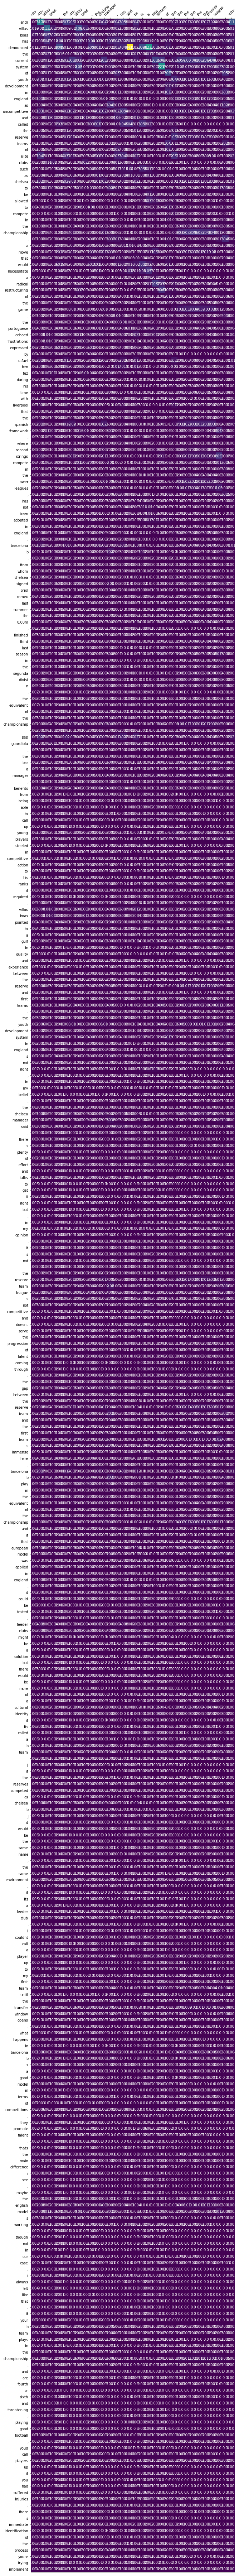

In [67]:
#width = round(len(out_text))

fig, ax = plt.subplots(figsize=(160,100))

im = plt.imshow(x, interpolation='nearest')


ax.set_xticks(np.arange(len(trans_)))
ax.set_yticks(np.arange(len(example_)))

ax.set_xticklabels(trans_)
ax.set_yticklabels(example_)

ax.xaxis.tick_top()

plt.setp(ax.get_xticklabels(), rotation=45)

for i in range(len(example_)):
    for j in range(len(trans_)):
        text = ax.text(j, i, x[i, j],
                       ha="center", va="center", color="w")


fig.tight_layout()
plt.show()
#plt.savefig('dissertation_cluster/figs/attention.pdf')

## Plotting encoder representations with UMAP

In [34]:

file_path = 'data/valid_section_labs.txt'
val_section_labels = []

with codecs.open(file_path) as file:
    for sent in file.readlines():
        val_section_labels.append(sent[:-1])
        
file_path = 'data/train_section_labs.txt'
train_section_labels = []

with codecs.open(file_path) as file:
    for sent in file.readlines():
        train_section_labels.append(sent[:-1])
        
        
file_path = 'data/test_shrt_section_labs.txt'
test_shrt_section_labels = []

with codecs.open(file_path) as file:
    for sent in file.readlines():
        test_shrt_section_labels.append(sent[:-1])       
        
        

In [35]:
# convert text labels to numeric

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

le.fit(train_section_labels)
train_sections = le.transform(train_section_labels)
val_sections = le.transform(val_section_labels)
test_shrt_sections = le.transform(test_shrt_section_labels)

In [36]:
def get_encoder_outputs(src_sents, src_seqs, src_lens, encoder):
    # -------------------------------------
    # Prepare input and output placeholders
    # -------------------------------------
    # Last batch might not have the same size as we set to the `batch_size`
    batch_size = src_seqs.size(1)

    
    # Pack tensors to variables for neural network inputs (in order to autograd)
    with torch.no_grad():
        src_seqs = src_seqs
        src_lens = torch.LongTensor(src_lens)
        
    if USE_CUDA:
        src_seqs = src_seqs.cuda()
        src_lens = src_lens.cuda()
        
    encoder.eval()
        
    # -------------------------------------
    # Forward encoder
    # -------------------------------------
    with torch.no_grad():
        encoder_outputs, encoder_hidden = encoder(src_seqs, src_lens.data.tolist())
    
    return encoder_outputs, encoder_hidden

In [71]:
dataset = test_shrt_iter
num_labs = test_shrt_sections

enc_outs = []
enc_hidden = []
enc_hidden_l1 = []
enc_hidden_l2 = []

for batch_id, batch_data in tqdm(enumerate(dataset)):
    src_sents, tgt_sents, tgt_tags, src_seqs, tgt1_seqs, tgt2_seqs, src_lens, tgt1_lens, tgt2_lens = batch_data
    
    encoder_outputs, encoder_hidden = get_encoder_outputs(src_sents, src_seqs, src_lens, encoder)
    
    encoder_outputs_cpu = encoder_outputs.cpu()
    encoder_hidden_l1_cpu = torch.cat((encoder_hidden[0][1],encoder_hidden[0][0]),1).cpu()
    encoder_hidden_l2_cpu = torch.cat((encoder_hidden[1][1],encoder_hidden[1][0]),1).cpu()
    
    encoder_outputs_np = encoder_outputs_cpu.data.numpy()
    encoder_hidden_l1_np = encoder_hidden_l1_cpu.data.numpy()
    encoder_hidden_l2_np = encoder_hidden_l2_cpu.data.numpy()
    
    enc_outs.append(encoder_outputs_np)
    enc_hidden_l1.append(encoder_hidden_l1_np)
    enc_hidden_l2.append(encoder_hidden_l2_np)


In [72]:
av_enc = []
for i in enc_outs:
    av_enc.append(np.sum(i, axis=0))

In [73]:
# opts {enc_state, enc_hidden_l1, enc_hidden_l2}
#layer_ = enc_hidden_l1

layer = np.vstack(av_enc)

In [86]:
reducer = umap.UMAP(n_neighbors=10, min_dist=0.2, metric='cosine')

In [87]:
embedding = reducer.fit_transform(layer)
embedding.shape

(3000, 2)

In [88]:
import hdbscan

In [89]:
cd ~

/afs/inf.ed.ac.uk/user/s04/s0451365


In [90]:
labels = hdbscan.HDBSCAN(
    min_samples=30,
    min_cluster_size=200
).fit_predict(embedding)

In [91]:
dbmin = min(labels)
dbmax = max(labels)
print(dbmin, dbmax)

-1 1


In [92]:
num_clusters = len(set(labels))
num_clusters

3

In [93]:
clusters = list(set(labels))

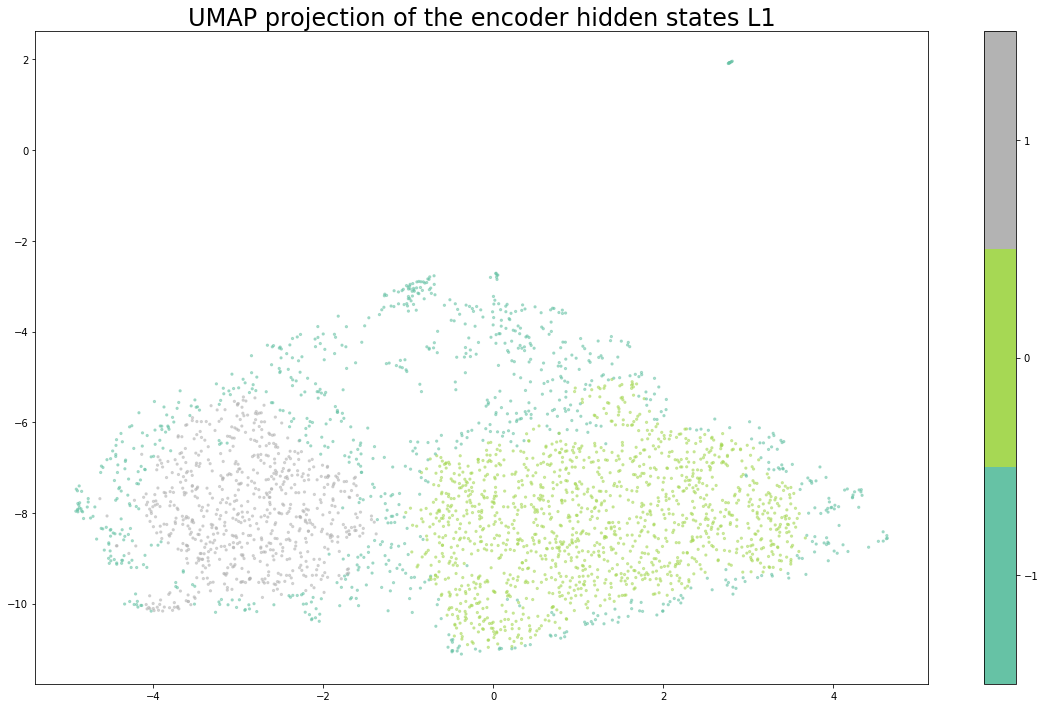

In [94]:
cmap = plt.get_cmap('Set2', num_clusters)

norm= matplotlib.colors.BoundaryNorm(np.arange(-1,num_clusters)-0.5, num_clusters)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
#norm = matplotlib.colors.BoundaryNorm(np.arange(dbmin,dbmax,1), cmap.N)

plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap=cmap, s=5, alpha=0.5)
#plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the encoder hidden states L1', fontsize=24);

sm.set_array([])
plt.colorbar(sm, ticks=np.arange(-1,num_clusters))

#savefig('dissertation_cluster/figs/umap_hidden_l1_clusters.pdf')

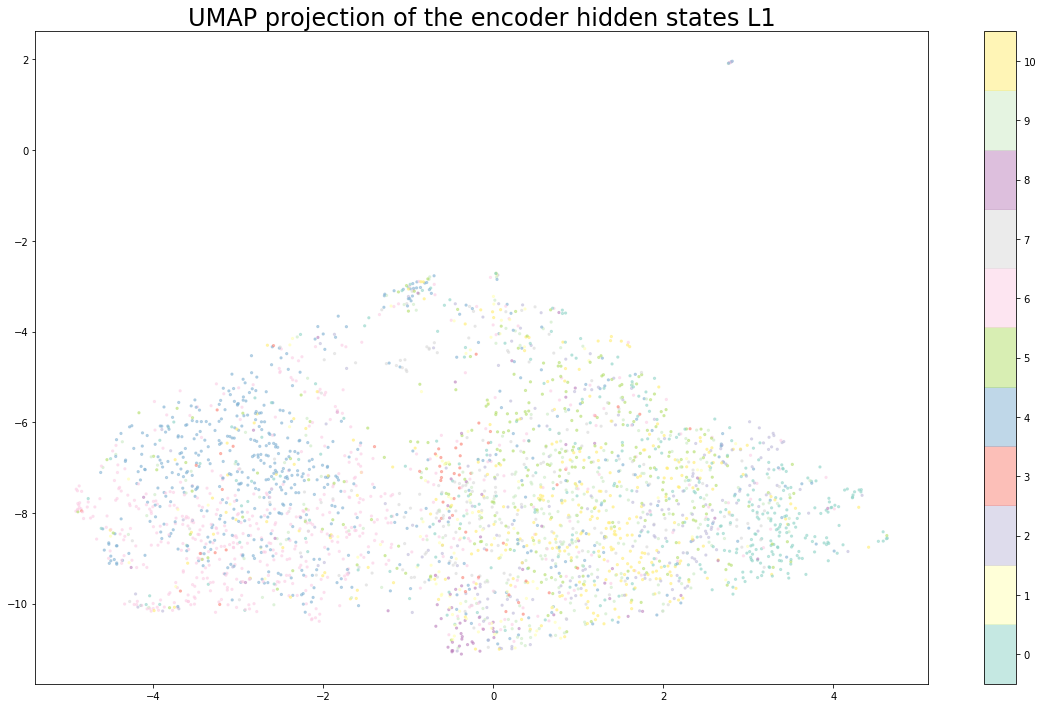

In [95]:
cmap = set_cmap('Set3')

#norm = matplotlib.colors.BoundaryNorm(np.arange(dbmin,dbmax,1), cmap.N)

plt.scatter(embedding[:, 0], embedding[:, 1], c=num_labs, cmap=cmap, s=5, alpha=0.5)
#plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(12)-0.5).set_ticks(np.arange(11))
plt.title('UMAP projection of the encoder hidden states L1', fontsize=24);
#colorbar_index(ncolors=11, cmap=cmap) 
#savefig('dissertation_cluster/figs/umap_hidden_l1_sections.pdf')

In [340]:
import pandas as pd

In [341]:
str(round(embedding[1][0],1)) + " , " + str(round(embedding[1][1],1))

'3.1 , -1.9'

In [342]:
src_text = []
tgt_text = []
coods = []

dataset = valid_dataset

for i in range(len(dataset)):
    src_text_ = " ".join(dataset.__getitem__(i)[0])
    tgt_text_ = " ".join(dataset.__getitem__(i)[1])
    coods_ = str(round(embedding[i][0],1)) + " , " + str(round(embedding[i][1],1))
    src_text.append(src_text_)
    tgt_text.append(tgt_text_)
    coods.append(coods_)

testout_df = pd.DataFrame(np.column_stack([src_text, tgt_text, out_texts, num_labs, labels, coods]), columns=['src_text', 'tgt_text', 'translation', 'section', 'cluster_lab', 'coords'])


In [362]:
testout_df.loc[testout_df['cluster_lab'] == '1']['src_text'].iloc[4]

'theresa may is not back pedalling on her pledge to give workers a voice on company boards , the business secretary has said in response to criticism of the government s announcement that it will not force companies to give employees a governance position . related : theresa may to unveil boardroom crackdown on private big business the government unveiled proposals on tuesday to tackle corporate excess . may had raised the prospect of placing employee representatives on boards during her conservative leadership campaign over the summer , but has since told businesses she will not make them do so . greg clark said the prime minister wanted workers to be represented , but not necessarily by having an employee on the board . we are not going to make it happen , he told bbc radio 0 s today programme , adding that the government did not want to overturn what has been a successful system which has had the confidence of business around the world . what we are proposing today is a range of pro

In [344]:
testout_df.loc[testout_df['cluster_lab'] == '2']

,src_text,tgt_text,translation,section,cluster_lab,coords
104,high street retailers gained some relief from ...,<t> retail sales show january surge . sales we...,<t> high street retailers gained some relief f...,0,2,"-0.0 , 2.8"
709,"brakes , the london based food supplier that h...",<t> brakes sold to us company sysco in $0.0bn ...,<t> brakes in london to us company sysco in de...,0,2,"0.0 , 2.7"
980,investors protested against pay policies at tw...,<t> inmarsat shareholders vote against pay pol...,<t> investors protested against pay policies a...,0,2,"-0.4 , 2.7"
1124,"over the past 00 years , an astounding one bil...",<t> making international trade work for the wo...,<t> the poor and poor : the world trade group ...,0,2,"-0.3 , 2.0"
1900,the grattan institute this week published a re...,<t> work until 00 ? why old dogs must learn ne...,<t> the grattan : the grattan of the age of th...,0,2,"-0.1 , 2.8"
1929,has the behemoth had its day ? after years of ...,<t> tesco and rivals turn against hypermarkets...,<t> tesco : the latest news and best aside in ...,0,2,"-0.3 , 2.9"
3322,"alex poots , the founding director of manchest...",<t> manchester international festival founding...,<t> alex trustee : the director of manchester ...,1,2,"-0.7 , 3.1"
3343,"in the afternoon of 0 june , the queen will ma...",<t> david starkey : i can be a bit harsh . whe...,<t> the queen elizabeth : the queen is the flo...,1,2,"-0.9 , 3.2"
3348,dear doctor new doctor peter capaldis who cred...,<t> populist : items of interest this week . f...,<t> the new trailer : the new trailer video is...,1,2,"-0.5 , 2.9"
3415,"comic con international , san diego s annual c...",<t> conan obrien kicks off comic con 0000 in m...,<t> the convention : the convention of the con...,1,2,"-0.6 , 2.9"


## predicting sections using encoder layer

In [44]:
class DropNet(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(512, 200)
        self.drop = nn.Dropout()
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 11)
        
    def forward(self, x):
        x = self.drop(x)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return F.log_softmax(x)

In [45]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(512, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 11)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x)

In [46]:
net = Net().cuda()
print(net)

Net(
  (fc1): Linear(in_features=512, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=11, bias=True)
)


In [47]:
# optimizer
learning_rate=0.01

optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
# loss function
criterion = nn.NLLLoss()

In [48]:
def forward_encoder_mlp(src_seqs, src_lens, tgt, encoder, mode='train'):
    # -------------------------------------
    # Prepare input and output placeholders
    # -------------------------------------
    # Last batch might not have the same size as we set to the `batch_size`
    batch_size = src_seqs.size(1)

    
    # Pack tensors to variables for neural network inputs (in order to autograd)
    with torch.no_grad():
        src_seqs = src_seqs
        src_lens = torch.LongTensor(src_lens)
        tgt = torch.LongTensor(tgt)
        
    if USE_CUDA:
        src_seqs = src_seqs.cuda()
        src_lens = src_lens.cuda()
        tgt = tgt.cuda()
        
    encoder.eval()
        
    # -------------------------------------
    # Forward encoder
    # -------------------------------------
    with torch.no_grad():
        encoder_outputs, encoder_hidden = encoder(src_seqs, src_lens.data.tolist())
        
        #encoder_hidden_l1 = torch.cat((encoder_hidden[0][1],encoder_hidden[0][0]),1)
        #encoder_hidden_l2 = torch.cat((encoder_hidden[1][1],encoder_hidden[1][0]),1)
        #latent_rep = torch.mean(encoder_outputs, dim=0)
        latent_rep = encoder_outputs[-1]
    
    if mode == 'test':
        with torch.no_grad():
            net_out = net(latent_rep)
    else:
        net_out = net(latent_rep)
    
    loss = criterion(net_out, torch.max(tgt, 1)[1])
    
    return net_out, loss, tgt

In [49]:
# run the main training loop
epochs = 1
dataset = train_mlp_iter
log_interval = 1000
iterations=0
correct=0

for epoch in range(epochs):
    for batch_id, batch_data in tqdm(enumerate(dataset)):
        src_sents, src_seqs, tgts, src_lens, scts = batch_data

        batch_size = len(src_sents)
        
        optimizer.zero_grad()
        
        net_out, loss, tgt = forward_encoder_mlp(src_seqs, src_lens, tgts, encoder, 'train')
        
        loss.backward()
        optimizer.step()
    
        pred = net_out.data.max(1)[1]  # get the index of the max log-probability
    
        iterations += batch_size
        correct += pred.eq(torch.max(tgt, 1)[1]).sum()
        
        if batch_id % log_interval == 0:
            print('Training Accuracy: {}/{} ({:.0f}%)\n'.format(
                   correct, iterations,
                100. * correct / iterations))

        # Free memory
        del src_sents, src_seqs, tgts, src_lens, net_out, loss, tgt

/afs/inf.ed.ac.uk/user/s04/s0451365/miniconda3/envs/jgrace1/lib/python3.5/site-packages/ipykernel/__main__.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training Accuracy: 5/128 (3%)

Training Accuracy: 25092/128128 (19%)




In [50]:
test_loss = 0
correct = 0

for batch_id, batch_data in tqdm(enumerate(valid_mlp_iter)):
    
    src_sents, src_seqs, tgts, src_lens, scts = batch_data
    
    net_out, loss, tgt = forward_encoder_mlp(src_seqs, src_lens, tgts, encoder, 'test')
    # sum up batch loss
    
    test_loss += loss
    pred = net_out.data.max(1)[1]  # get the index of the max log-probability
    
    correct += pred.eq(torch.max(tgt, 1)[1]).sum()

test_loss /= valid_mlp_dataset.__len__()
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, valid_mlp_dataset.__len__(),
        100. * correct / valid_mlp_dataset.__len__()))

/afs/inf.ed.ac.uk/user/s04/s0451365/miniconda3/envs/jgrace1/lib/python3.5/site-packages/ipykernel/__main__.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.




Test set: Average loss: 0.2742, Accuracy: 5266/25507 (20.00%)



In [49]:
from random import shuffle

In [62]:
val_section_labels_rnd = val_section_labels.copy()

shuffle(val_section_labels_rnd)

In [73]:
accs = []
for t in range(5):
    match = 0
    shuffle(val_section_labels_rnd)
    for i,j in zip(val_section_labels, val_section_labels_rnd):
        if i == j:
            match += 1
        
    acc = match/len(val_section_labels)
    accs.append(acc)
print(accs)
print('Chance level accuracy: ', round(100*np.mean(accs),2), '%')

[0.12192731407064727, 0.12392676520170934, 0.12475006860861725, 0.12463245383620182, 0.12498529815344807]
Chance level accuracy:  12.4 %


## Train RNN classifier

In [29]:
class RNN_classifier(nn.Module):
    def __init__(self, embedding=None, rnn_type='LSTM', hidden_size=256, num_layers=2, dropout=0, bidirectional=True):
        super(RNN_classifier, self).__init__()
        
        self.num_layers = num_layers
        self.dropout = dropout
        #self.drop = nn.Dropout()
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        self.hidden_size = hidden_size // self.num_directions
        
        self.embedding = embedding
        self.word_vec_size = self.embedding.embedding_dim
        
        self.rnn_type = rnn_type
        self.rnn = getattr(nn, self.rnn_type)(
                           input_size=self.word_vec_size,
                           hidden_size=self.hidden_size,
                           num_layers=self.num_layers,
                           dropout=self.dropout, 
                           bidirectional=self.bidirectional)
        
        self.fc1 = nn.Linear(256, 11)
        
    def forward(self, src_seqs, src_lens, hidden=None):
        """
        Args:
            - src_seqs: (max_src_len, batch_size)
            - src_lens: (batch_size)
        Returns:
            - outputs: (max_src_len, batch_size, hidden_size * num_directions)
            - hidden : (num_layers, batch_size, hidden_size * num_directions)
        """
        
        # (max_src_len, batch_size) => (max_src_len, batch_size, word_vec_size)
        emb = self.embedding(src_seqs)

        # packed_emb:
        # - data: (sum(batch_sizes), word_vec_size)
        # - batch_sizes: list of batch sizes
        packed_emb = nn.utils.rnn.pack_padded_sequence(emb, src_lens)
        

        # rnn(gru) returns:
        # - packed_outputs: shape same as packed_emb
        # - hidden: (num_layers * num_directions, batch_size, hidden_size) 
        packed_outputs, hidden = self.rnn(packed_emb, hidden)

        # outputs: (max_src_len, batch_size, hidden_size * num_directions)
        # output_lens == src_lensˇ
        outputs, output_lens =  nn.utils.rnn.pad_packed_sequence(packed_outputs)
        
        #hidden_ = torch.cat((hidden[0][1],hidden[0][0]),1)
        #context = torch.cat((hidden[1][1],hidden[1][0]),1)
        
        if self.bidirectional:
            # (num_layers * num_directions, batch_size, hidden_size) 
            # => (num_layers, batch_size, hidden_size * num_directions)
            hidden = self._cat_directions(hidden)
        
        #drop = self.drop(hidden_l1)
            
        # MLP takes one hidden layer. ix here is the encoder layer
        x = F.relu(self.fc1(outputs[-1]))
        #x = F.dropout(x, training=self.training)
        #x = F.relu(self.fc2(x))
        #x = F.dropout(x, training=self.training)
        #x = self.fc3(x)
        return F.log_softmax(x, dim=1)
    
    def _cat_directions(self, hidden):
        """ If the encoder is bidirectional, do the following transformation.
            Ref: https://github.com/IBM/pytorch-seq2seq/blob/master/seq2seq/models/DecoderRNN.py#L176
            -----------------------------------------------------------
            In: (num_layers * num_directions, batch_size, hidden_size)
            (ex: num_layers=2, num_directions=2)

            layer 1: forward__hidden(1)
            layer 1: backward_hidden(1)
            layer 2: forward__hidden(2)
            layer 2: backward_hidden(2)

            -----------------------------------------------------------
            Out: (num_layers, batch_size, hidden_size * num_directions)

            layer 1: forward__hidden(1) backward_hidden(1)
            layer 2: forward__hidden(2) backward_hidden(2)
        """
        def _cat(h):
            return torch.cat([h[0:h.size(0):2], h[1:h.size(0):2]], 2)
            
        if isinstance(hidden, tuple):
            # LSTM hidden contains a tuple (hidden state, cell state)
            hidden = tuple([_cat(h) for h in hidden])
        else:
            # GRU hidden
            hidden = _cat(hidden)
            
        return hidden

In [30]:
# Initialize models.
RNNclassifier = RNN_classifier(embedding=src_embedding,
                     rnn_type='GRU',
                     hidden_size=256,
                     num_layers=1,
                     dropout=0,
                     bidirectional=True)

if USE_CUDA:
    RNNclassifier.cuda()

In [31]:
print(RNNclassifier)

RNN_classifier(
  (embedding): Embedding(50004, 300, padding_idx=0)
  (rnn): GRU(300, 128, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=11, bias=True)
)


In [35]:
tgt

NameError: name 'tgt' is not defined

In [32]:
# Initialize optimizers (we can experiment different learning rates)
RNNclassifier_optim = optim.Adam([p for p in RNNclassifier.parameters() if p.requires_grad], lr = 1e-3)
#RNNclassifier_optim = optim.RMSprop([p for p in RNNclassifier.parameters() if p.requires_grad])
#RNNclassifier_optim = optim.SGD(RNNclassifier.parameters(), lr = 1e-2)

# loss function
#criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()

In [54]:
def RNN_classifier(src_seqs, src_lens, tgt, mode='train'):
    # -------------------------------------
    # Prepare input and output placeholders
    # -------------------------------------
    # Last batch might not have the same size as we set to the `batch_size`
    batch_size = src_seqs.size(1)
    
    # Pack tensors to variables for neural network inputs (in order to autograd)
    src_seqs = src_seqs
    src_lens = torch.LongTensor(src_lens)
    tgt = torch.LongTensor(tgt)
    
    assert(batch_size == tgt.size(0))
        
    if USE_CUDA:
        src_seqs = src_seqs.cuda()
        src_lens = src_lens.cuda()
        tgt = tgt.cuda()
    
    if mode == 'train':
        
        RNNclassifier.train()
        
    # -------------------------------------
    # Zero gradients, since optimizers will accumulate gradients for every backward.
    # -------------------------------------
        RNNclassifier_optim.zero_grad()
        
        RNNclass_out = RNNclassifier(src_seqs, src_lens.data.tolist())
        
        loss = criterion(RNNclass_out, torch.max(tgt, 1)[1])
        
        loss.backward()
        
            # Clip gradients
        RNNclassifier_grad_norm = nn.utils.clip_grad_norm_(RNNclassifier.parameters(), opts.max_grad_norm)
        clipped_RNNclassifier_grad_norm = compute_grad_norm(RNNclassifier.parameters())

    
        RNNclassifier_optim.step()
        
        
    
    elif mode == 'test':
        
        RNNclassifier.eval()
    # -------------------------------------
    # Forward encoder
    # -------------------------------------
        with torch.no_grad():
            RNNclass_out = RNNclassifier(src_seqs, src_lens.data.tolist())
    
            loss = criterion(RNNclass_out, torch.max(tgt, 1)[1])
        
    
    return RNNclass_out, loss, tgt

In [39]:
for batch_id, batch_data in tqdm(enumerate(valid_mlp_iter)):
        src_sents, src_seqs, tgts, src_lens, scts = batch_data

In [53]:
torch.LongTensor(tgts).size(0)

128

In [55]:
# train LSTM encoder + MLP for max accuracy
experiment_name = 'RNN_classifier_dropout_seqs400'

total_loss = 0
total_corrects = 0
total_words = 0
global_step = 0
iterations = 0

epochs = 1
dataset = train_mlp_iter
log_interval = 200

for epoch in range(epochs):
    for batch_id, batch_data in tqdm(enumerate(dataset)):
        src_sents, src_seqs, tgts, src_lens, scts = batch_data

        batch_size = len(src_sents)
    
        
        RNNclass_out, loss, tgt = RNN_classifier(src_seqs, src_lens, tgts, 'train')
    
        pred = RNNclass_out.data.max(1)[1]  # get the index of the max log-probability
    
        iterations += batch_size
        num_corrects = pred.eq(torch.max(tgt, 1)[1]).sum()
        
        batch_accuracy = round(100 * (float(num_corrects) / batch_size))
        global_step += 1
        total_loss += loss
        total_corrects += num_corrects
        total_accuracy = round(100 * (total_corrects.item() / iterations),2)
        avg_loss = round(100 * (total_loss.item() / iterations),2)
        
        if batch_id % log_interval == 0:
            print('Training: Overall Accuracy: {}/{} ({:.0f}%), batch accuracy: {}, loss: {}\n'.format(
                   total_corrects, iterations,
                total_accuracy,batch_accuracy, avg_loss))

        # Free memory
        del src_sents, src_seqs, tgts, src_lens, RNNclass_out, loss, tgt

/afs/inf.ed.ac.uk/user/s04/s0451365/miniconda3/envs/jgrace1/lib/python3.5/site-packages/ipykernel/__main__.py:36: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Training: Overall Accuracy: 31/128 (24%), batch accuracy: 24, loss: 1.86

Training: Overall Accuracy: 5029/25728 (20%), batch accuracy: 23, loss: 1.77

Training: Overall Accuracy: 11157/51328 (22%), batch accuracy: 28, loss: 1.71

Training: Overall Accuracy: 19011/76928 (25%), batch accuracy: 35, loss: 1.65

Training: Overall Accuracy: 27631/102528 (27%), batch accuracy: 40, loss: 1.6

Training: Overall Accuracy: 37042/128128 (29%), batch accuracy: 45, loss: 1.56

Training: Overall Accuracy: 47661/153728 (31%), batch accuracy: 41, loss: 1.53

Training: Overall Accuracy: 59000/179328 (33%), batch accuracy: 40, loss: 1.5




In [ ]:
#experiment_name = 'RNN_classifier_dropout_seqs1000'

In [39]:
def save_class_checkpoint(opts, experiment_name, encoder, encoder_optim,
                    total_accuracy, total_loss, global_step):
    checkpoint = {
        'opts': opts,
        'global_step': global_step,
        'encoder_state_dict': RNNclassifier.state_dict(),
        'encoder_optim_state_dict': RNNclassifier_optim.state_dict()
    }
    
    checkpoint_path = 'checkpoints/%s_acc_%.2f_loss_%.2f_step_%d.pt' % (experiment_name, total_accuracy, total_loss, global_step)
    
    directory, filename = os.path.split(os.path.abspath(checkpoint_path))

    if not os.path.exists(directory):
        os.makedirs(directory)
    
    torch.save(checkpoint, checkpoint_path)
    
    return checkpoint_path

In [ ]:
checkpoint_path = save_class_checkpoint(opts, experiment_name, encoder, encoder_optim, 
                                              total_accuracy, total_loss, global_step)

In [35]:
LOAD_CHECKPOINT = True

if LOAD_CHECKPOINT:
    # Modify this path.
    checkpoint_path = 'checkpoints/RNN_classifier_dropout_base_acc_53.14_loss_17432.52_step_12754.pt'
    checkpoint = load_checkpoint(checkpoint_path)
    opts = checkpoint['opts']    
    
if LOAD_CHECKPOINT:
    RNNclassifier.load_state_dict(checkpoint['encoder_state_dict'])

RuntimeError: Error(s) in loading state_dict for RNN_classifier:
	Unexpected key(s) in state_dict: "fc2.weight", "fc2.bias", "fc3.weight", "fc3.bias". 
	While copying the parameter named "rnn.bias_ih_l0_reverse", whose dimensions in the model are torch.Size([512]) and whose dimensions in the checkpoint are torch.Size([1024]).
	While copying the parameter named "rnn.bias_ih_l1", whose dimensions in the model are torch.Size([512]) and whose dimensions in the checkpoint are torch.Size([1024]).
	While copying the parameter named "rnn.bias_hh_l1", whose dimensions in the model are torch.Size([512]) and whose dimensions in the checkpoint are torch.Size([1024]).
	While copying the parameter named "rnn.bias_ih_l1_reverse", whose dimensions in the model are torch.Size([512]) and whose dimensions in the checkpoint are torch.Size([1024]).
	While copying the parameter named "rnn.bias_hh_l0", whose dimensions in the model are torch.Size([512]) and whose dimensions in the checkpoint are torch.Size([1024]).
	While copying the parameter named "rnn.weight_ih_l0", whose dimensions in the model are torch.Size([512, 300]) and whose dimensions in the checkpoint are torch.Size([1024, 300]).
	While copying the parameter named "rnn.weight_hh_l1_reverse", whose dimensions in the model are torch.Size([512, 128]) and whose dimensions in the checkpoint are torch.Size([1024, 256]).
	While copying the parameter named "rnn.bias_ih_l0", whose dimensions in the model are torch.Size([512]) and whose dimensions in the checkpoint are torch.Size([1024]).
	While copying the parameter named "rnn.bias_hh_l0_reverse", whose dimensions in the model are torch.Size([512]) and whose dimensions in the checkpoint are torch.Size([1024]).
	While copying the parameter named "rnn.bias_hh_l1_reverse", whose dimensions in the model are torch.Size([512]) and whose dimensions in the checkpoint are torch.Size([1024]).
	While copying the parameter named "rnn.weight_ih_l0_reverse", whose dimensions in the model are torch.Size([512, 300]) and whose dimensions in the checkpoint are torch.Size([1024, 300]).
	While copying the parameter named "rnn.weight_ih_l1_reverse", whose dimensions in the model are torch.Size([512, 256]) and whose dimensions in the checkpoint are torch.Size([1024, 512]).
	While copying the parameter named "rnn.weight_hh_l1", whose dimensions in the model are torch.Size([512, 128]) and whose dimensions in the checkpoint are torch.Size([1024, 256]).
	While copying the parameter named "rnn.weight_hh_l0", whose dimensions in the model are torch.Size([512, 128]) and whose dimensions in the checkpoint are torch.Size([1024, 256]).
	While copying the parameter named "rnn.weight_ih_l1", whose dimensions in the model are torch.Size([512, 256]) and whose dimensions in the checkpoint are torch.Size([1024, 512]).
	While copying the parameter named "rnn.weight_hh_l0_reverse", whose dimensions in the model are torch.Size([512, 128]) and whose dimensions in the checkpoint are torch.Size([1024, 256]).
	While copying the parameter named "fc1.weight", whose dimensions in the model are torch.Size([11, 256]) and whose dimensions in the checkpoint are torch.Size([200, 1024]).
	While copying the parameter named "fc1.bias", whose dimensions in the model are torch.Size([11]) and whose dimensions in the checkpoint are torch.Size([200]).

In [56]:
test_loss = 0
correct = 0
preds = []
tgts_ = []

for batch_id, batch_data in tqdm(enumerate(valid_mlp_iter)):
    
    src_sents, src_seqs, tgts, src_lens, scts = batch_data
    
    RNNclass_out, loss, tgt = RNN_classifier(src_seqs, src_lens, tgts, 'test')
    # sum up batch loss
   
    test_loss += loss
    pred = RNNclass_out.data.max(1)[1]  # get the index of the max log-probability
    
    tgt_ = torch.max(tgt, 1)[1]
    correct += pred.eq(tgt_).sum()
    
    preds.append(pred)
    tgts_.append(tgt_)
    
    # Free memory
    del src_sents, src_seqs, src_lens

test_loss /= valid_mlp_dataset.__len__()
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, valid_mlp_dataset.__len__(),
        100 * correct / valid_mlp_dataset.__len__()))



Test set: Average loss: 0.2872, Accuracy: 6413/25507 (25%)

